In [1]:
from dipy.io.streamline import load_trk
import numpy as np
from tqdm import tqdm
from dataset_handlers import HCPHandler, TractoinfernoHandler
import pandas as pd
import os
import pathlib2 as pathlib
import matplotlib.pyplot as plt

# HCP 105 dataset

In [2]:
ds_path = "/app/dataset/HCP_105"

handler = HCPHandler(path = ds_path, scope = "trainset")
train_data = handler.get_data()

handler = HCPHandler(path = ds_path, scope = "validset")
valid_data = handler.get_data()

handler = HCPHandler(path = ds_path, scope = "testset")
test_data = handler.get_data()

{0: 'AF_left', 1: 'AF_right', 2: 'ATR_left', 3: 'ATR_right', 4: 'CA', 5: 'CC_1', 6: 'CC_2', 7: 'CC_3', 8: 'CC_4', 9: 'CC_5', 10: 'CC_6', 11: 'CC_7', 12: 'CC', 13: 'CG_left', 14: 'CG_right', 15: 'CST_left', 16: 'CST_right', 17: 'MLF_left', 18: 'MLF_right', 19: 'FPT_left', 20: 'FPT_right', 21: 'FX_left', 22: 'FX_right', 23: 'ICP_left', 24: 'ICP_right', 25: 'IFO_left', 26: 'IFO_right', 27: 'ILF_left', 28: 'ILF_right', 29: 'MCP', 30: 'OR_left', 31: 'OR_right', 32: 'POPT_left', 33: 'POPT_right', 34: 'SCP_left', 35: 'SCP_right', 36: 'SLF_I_left', 37: 'SLF_I_right', 38: 'SLF_II_left', 39: 'SLF_II_right', 40: 'SLF_III_left', 41: 'SLF_III_right', 42: 'STR_left', 43: 'STR_right', 44: 'UF_left', 45: 'UF_right', 46: 'T_PREF_left', 47: 'T_PREF_right', 48: 'T_PREM_left', 49: 'T_PREM_right', 50: 'T_PREC_left', 51: 'T_PREC_right', 52: 'T_POSTC_left', 53: 'T_POSTC_right', 54: 'T_PAR_left', 55: 'T_PAR_right', 56: 'T_OCC_left', 57: 'T_OCC_right', 58: 'ST_FO_left', 59: 'ST_FO_right', 60: 'ST_PREF_left', 6

In [3]:
if pathlib.Path("/app/preprocessing/hcp105_streamline_count.csv").exists():
    print("El archivo ya existe. Cargando...")
    df = pd.read_csv("/app/preprocessing/hcp105_streamline_count.csv")
    
    
else:
    # Obtener un recuento de fibras por sujeto y por conjunto
    df = pd.DataFrame(columns=['subject_id', 'split', 'tract', 'streamline_count'])

    for data, name in zip([train_data, valid_data, test_data], ["train", "valid", "test"]):
        print(f"\n{name} set")
        for subj in data:
            row = {
                'subject_id' : subj['subject'], 
                'split' : subj['subject_split'], 
                'tract' : None, 
                'streamline_count': 0
            }

            for tract in subj['tracts']:
                # PosixPath('/app/dataset/HCP_105/792766/tracts/CC_1.trk')
                row['tract'] = tract.stem
                row['streamline_count'] = len(load_trk(str(tract), 'same', bbox_valid_check=False).streamlines)
                df.loc[len(df)] = row

    # Guardar el dataframe en un archivo csv en el directorio /app/preprocessing
    df.to_csv("/app/preprocessing/hcp105_streamline_count.csv", index=False)
    print("El archivo se ha guardado correctamente")            

El archivo ya existe. Cargando...


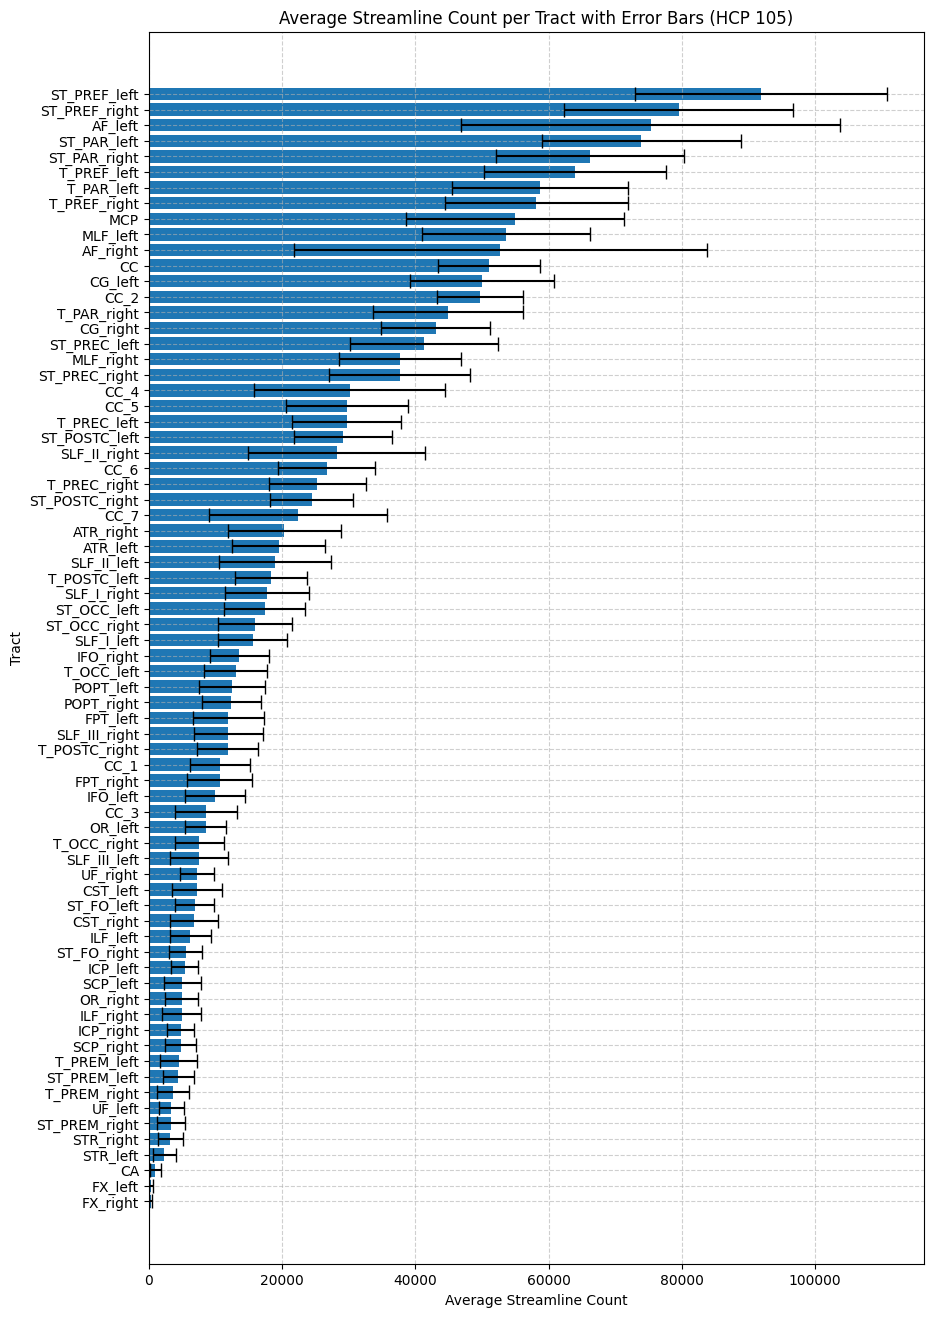

In [4]:
# Calcular el promedio y la desviación estándar del conteo de fibras por tracto
tract_stats = df.groupby('tract')['streamline_count'].agg(['mean', 'std']).reset_index()

# Ordenar los tractos por el promedio de conteo de fibras
tract_stats = tract_stats.sort_values(by='mean', ascending=True)

# Crear el gráfico de barras horizontales
plt.figure(figsize=(10, 16))
plt.barh(tract_stats['tract'], tract_stats['mean'], xerr=tract_stats['std'], capsize=5)
plt.xlabel('Average Streamline Count')
plt.ylabel('Tract')
plt.title('Average Streamline Count per Tract with Error Bars (HCP 105)')
plt.grid(True, linestyle='--', alpha=0.6)

# Mostrar el gráfico
plt.show()


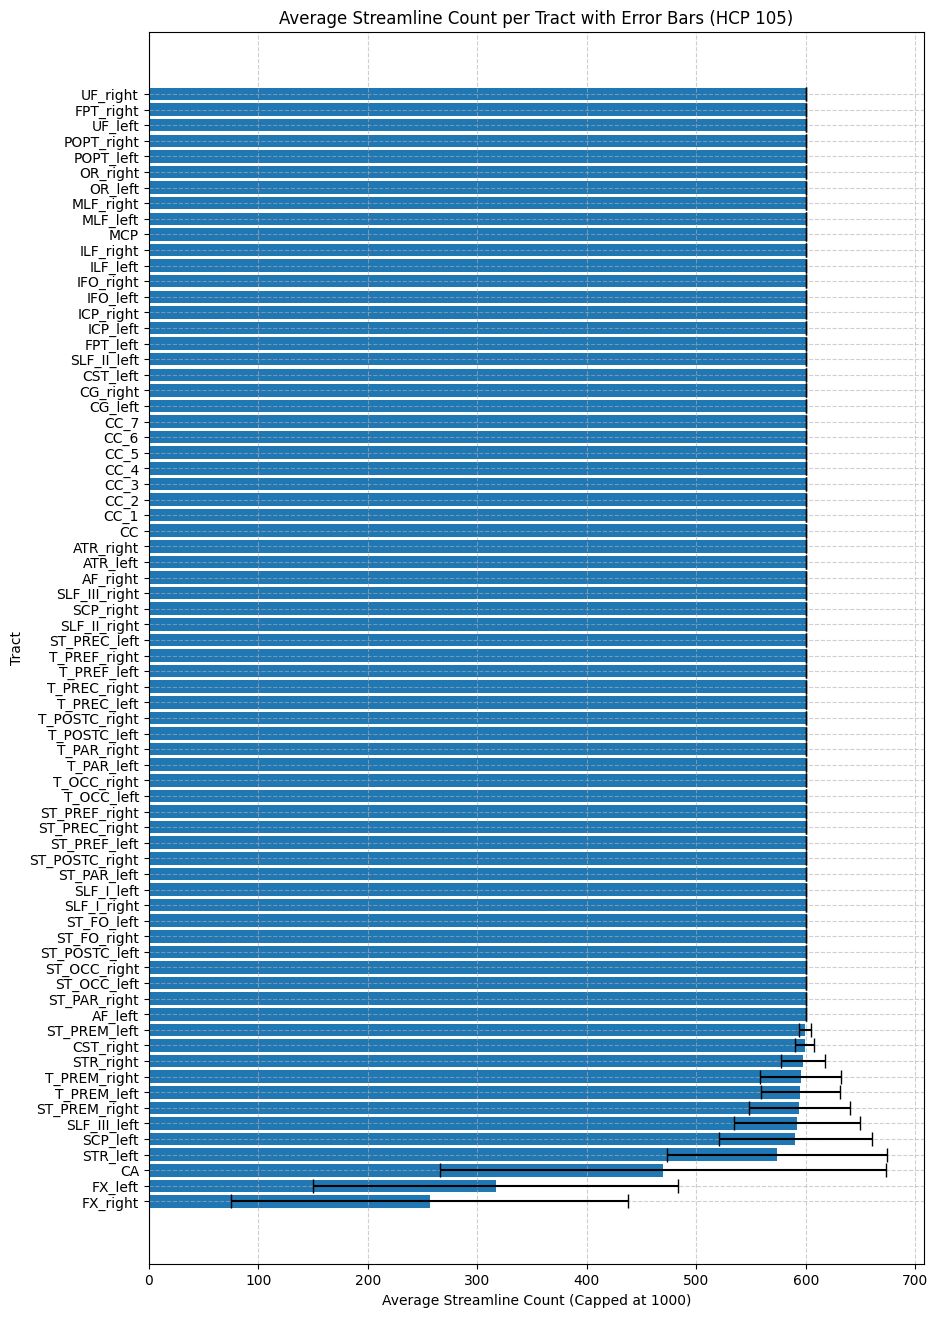

In [10]:
max_streamlines_per_tract = 600
# Ahora quiero que crees otra columna con la siguiente condicion: si recuento de fibras es > 1000 el valor sera 1000, si no, el valor sera el mismo que el recuento de fibras
df['streamline_count_capped'] = df['streamline_count'].apply(lambda x: max_streamlines_per_tract if x > max_streamlines_per_tract else x)

# Calcular el promedio y la desviación estándar del conteo de fibras por tracto
tract_stats_capped = df.groupby('tract')['streamline_count_capped'].agg(['mean', 'std']).reset_index()

# Ordenar los tractos por el promedio de conteo de fibras
tract_stats_capped = tract_stats_capped.sort_values(by='mean', ascending=True)

# Crear el gráfico de barras horizontales
plt.figure(figsize=(10, 16))
plt.barh(tract_stats_capped['tract'], tract_stats_capped['mean'], xerr=tract_stats_capped['std'], capsize=5)
plt.xlabel('Average Streamline Count (Capped at 1000)')
plt.ylabel('Tract')
plt.title('Average Streamline Count per Tract with Error Bars (HCP 105)')
plt.grid(True, linestyle='--', alpha=0.6)

# Mostrar el gráfico
plt.show()


In [11]:
# Pesos del loss function para cada tracto

# Calcular la suma de fibras por tracto
tract_frequencies = df.groupby('tract')['streamline_count_capped'].sum().reset_index()
tract_frequencies.columns = ['tract', 'total_fibers']

# Calcular el peso inverso de la frecuencia
tract_frequencies['weight'] = 1 / tract_frequencies['total_fibers']

# Normalizar los pesos para que su suma sea igual al número de clases
tract_frequencies['weight'] /= tract_frequencies['weight'].sum()

# Mostrar los pesos
tract_frequencies = tract_frequencies.sort_values(by='tract').reset_index(drop=True)
# import ace_tools as tools; tools.display_dataframe_to_user(name="Tract Weights", dataframe=tract_frequencies)
tract_frequencies

# Imprimir los pesos en forma de lista con sus respectivas comas para copiar y pegar en el código

tract_weights = tract_frequencies['weight'].values

print(tract_weights)
print(tract_weights.tolist())



[0.01340191 0.01340191 0.01340191 0.01340191 0.01711125 0.01340191
 0.01340191 0.01340191 0.01340191 0.01340191 0.01340191 0.01340191
 0.01340191 0.01340191 0.01340191 0.01340191 0.01342087 0.01340191
 0.01340191 0.0253702  0.03133495 0.01340191 0.01340191 0.01340191
 0.01340191 0.01340191 0.01340191 0.01340191 0.01340191 0.01340191
 0.01340191 0.01340191 0.01340191 0.01340191 0.01361785 0.01340191
 0.01358039 0.01340191 0.01340191 0.01340191 0.01340191 0.01340191
 0.01401967 0.01346238 0.01340191 0.01340191 0.01340191 0.01340191
 0.01340191 0.01340191 0.01340191 0.01340191 0.01340191 0.01340191
 0.01340191 0.01340191 0.01341383 0.0135349  0.01340191 0.01340191
 0.01340191 0.01340191 0.01340191 0.01340191 0.01340191 0.01340191
 0.01340191 0.01340191 0.01351302 0.0135061  0.01340191 0.01340191]
[0.013401909801331097, 0.013401909801331097, 0.013401909801331097, 0.013401909801331097, 0.017111248150373085, 0.013401909801331097, 0.013401909801331097, 0.013401909801331097, 0.0134019098013310

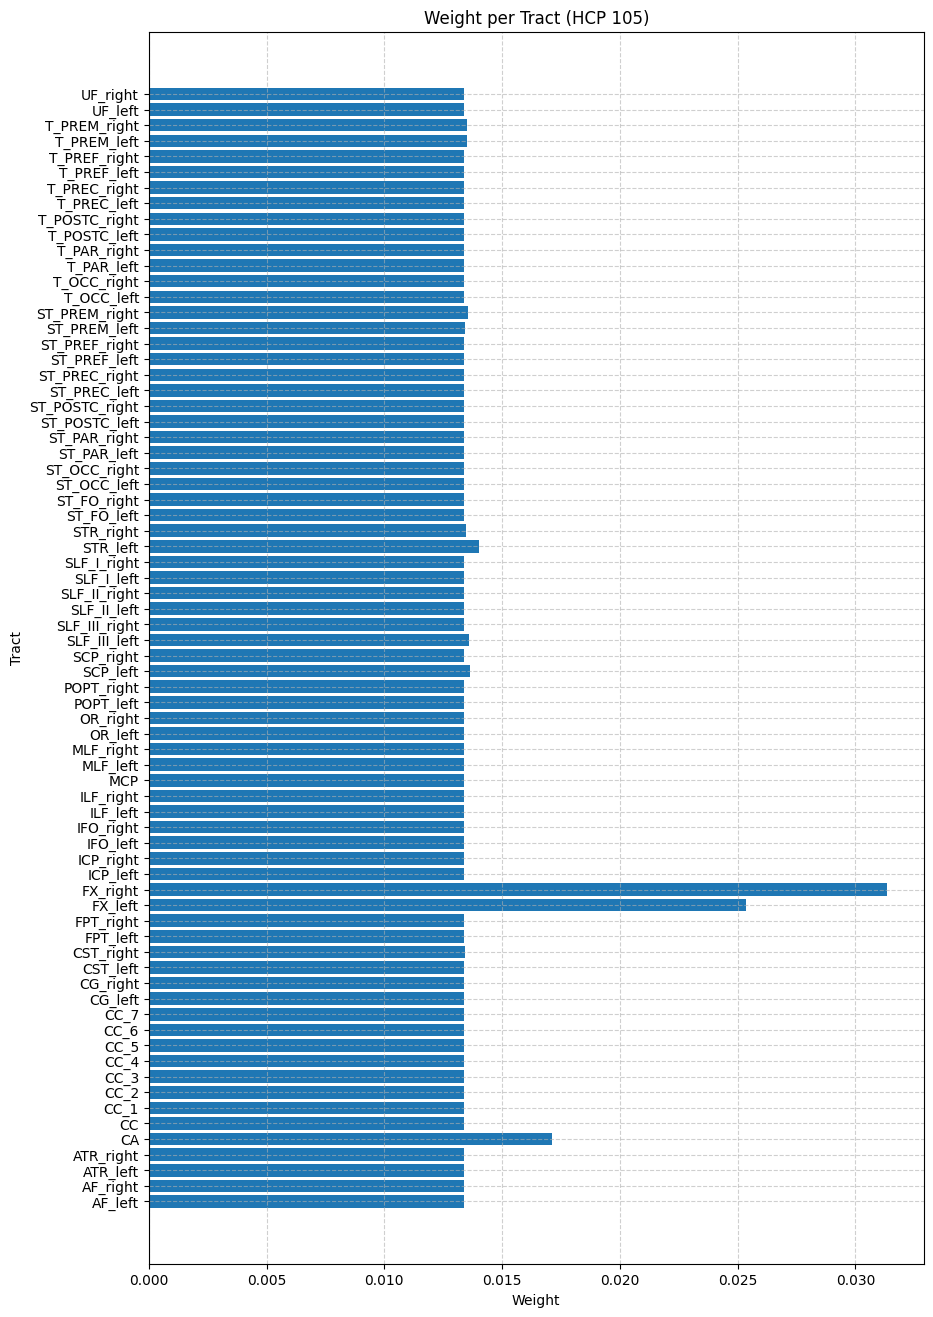

In [12]:
# Grafico de pesos de los tractos
plt.figure(figsize=(10, 16))
plt.barh(tract_frequencies['tract'], tract_frequencies['weight'])
plt.xlabel('Weight')
plt.ylabel('Tract')
plt.title('Weight per Tract (HCP 105)')
plt.grid(True, linestyle='--', alpha=0.6)

# Mostrar el gráfico
plt.show()


In [ ]:
# Pesos del loss function para cada tracto

# Calcular la suma de fibras por tracto
tract_frequencies = df.groupby('tract')['streamline_count'].sum().reset_index()
tract_frequencies.columns = ['tract', 'total_fibers']

# Calcular el peso inverso de la frecuencia
tract_frequencies['weight'] = 1 / tract_frequencies['total_fibers']

# Normalizar los pesos para que su suma sea igual al número de clases
tract_frequencies['weight'] /= tract_frequencies['weight'].sum()

# Mostrar los pesos
tract_frequencies = tract_frequencies.sort_values(by='tract').reset_index(drop=True)
# import ace_tools as tools; tools.display_dataframe_to_user(name="Tract Weights", dataframe=tract_frequencies)
tract_frequencies

# Imprimir los pesos en forma de lista
tract_weights = tract_frequencies['weight'].values
print(tract_weights)

In [ ]:
# Sumar la columna weight para verificar que la suma sea 1
print(f"Suma de pesos: {tract_frequencies['weight'].sum()}")

# TractoInferno Dataset

In [ ]:
ds_path = "/app/dataset/Tractoinferno/tractoinferno_preprocessed_mni"

handler = TractoinfernoHandler(path = ds_path, scope = "trainset")
train_data = handler.get_data()

handler = TractoinfernoHandler(path = ds_path, scope = "validset")
valid_data = handler.get_data()

handler = TractoinfernoHandler(path = ds_path, scope = "testset")
test_data = handler.get_data()

In [ ]:

x_coords, y_coords, z_coords = [], [], []

# Obtener los valores máximos y mínimos de cada eje x, y, z para cada sujeto en el dataset
progbar = tqdm(train_data)
for subject_dict in progbar:
    coords = {'x': [], 'y': [], 'z': []}
    
    for tract in subject_dict['tracts']:
        tract = load_trk(str(tract), 'same', bbox_valid_check=False)
        tract = tract.streamlines

        for fiber in tract:
            max_vals = np.max(fiber, axis=0)
            min_vals = np.min(fiber, axis=0)

            # Agregar los valores a la lista de coordenadas del sujeto actual
            coords['x'].extend([max_vals[0], min_vals[0]])
            coords['y'].extend([max_vals[1], min_vals[1]])
            coords['z'].extend([max_vals[2], min_vals[2]])

    # Añadir los valores máximos de coords['x'], ... y mínimos de cada eje del sujeto actual a la lista global
    x_coords.append(max(coords['x']))
    x_coords.append(min(coords['x']))

    y_coords.append(max(coords['y']))
    y_coords.append(min(coords['y']))

    z_coords.append(max(coords['z']))
    z_coords.append(min(coords['z']))

    progbar.set_description(f'x_max: {max(coords["x"]):.2f}, x_min: {min(coords["x"]):.2f}, y_max: {max(coords["y"]):.2f}, y_min: {min(coords["y"]):.2f}, z_max: {max(coords["z"]):.2f}, z_min: {min(coords["z"]):.2f}')

# Imprimir los valores máximos y mínimos globales
print('Max x: ', max(x_coords))
print('Max y: ', max(y_coords))
print('Max z: ', max(z_coords))
print('Min x: ', min(x_coords))
print('Min y: ', min(y_coords))
print('Min z: ', min(z_coords))

In [ ]:
train_data[0]

In [ ]:
if pathlib.Path("/app/preprocessing/tractoinferno_streamline_count.csv").exists():
    print("El archivo ya existe. Cargando...")
    df = pd.read_csv("/app/preprocessing/tractoinferno_streamline_count.csv")
    
else:
    # Obtener un recuento de fibras por sujeto y por conjunto
    df = pd.DataFrame(columns=['subject_id', 'split', 'tract', 'streamline_count'])

    for data, name in zip([train_data, valid_data, test_data], ["train", "valid", "test"]):
        print(f"\n{name} set")
        for subj in data:
            row = {
                'subject_id' : subj['subject'], 
                'split' : subj['subject_split'], 
                'tract' : None, 
                'streamline_count': 0
            }

            for tract in subj['tracts']:
                # PosixPath('/app/dataset/HCP_105/792766/tracts/CC_1.trk')
                row['tract'] = tract.stem
                row['streamline_count'] = len(load_trk(str(tract), 'same', bbox_valid_check=False).streamlines)
                df.loc[len(df)] = row

    # Guardar el dataframe en un archivo csv en el directorio /app/preprocessing
    df.to_csv("/app/preprocessing/tractoinferno_streamline_count.csv", index=False)
    print("El archivo se ha guardado correctamente")  

In [ ]:
# Calcular el promedio y la desviación estándar del conteo de fibras por tracto
tract_stats = df.groupby('tract')['streamline_count'].agg(['mean', 'std']).reset_index()

# Ordenar los tractos por el promedio de conteo de fibras
tract_stats = tract_stats.sort_values(by='mean', ascending=True)

# Crear el gráfico de barras horizontales
plt.figure(figsize=(10, 16))
plt.barh(tract_stats['tract'], tract_stats['mean'], xerr=tract_stats['std'], capsize=5)
plt.xlabel('Average Streamline Count')
plt.ylabel('Tract')
plt.title('Average Streamline Count per Tract with Error Bars (Tractoinferno)')
plt.grid(True, linestyle='--', alpha=0.6)

# Mostrar el gráfico
plt.show()

In [ ]:
# Pesos del loss function para cada tracto

# Calcular la suma de fibras por tracto
tract_frequencies = df.groupby('tract')['streamline_count'].sum().reset_index()
tract_frequencies.columns = ['tract', 'total_fibers']

# Calcular el peso inverso de la frecuencia
tract_frequencies['weight'] = 1 / tract_frequencies['total_fibers']

# Normalizar los pesos para que su suma sea igual al número de clases
tract_frequencies['weight'] /= tract_frequencies['weight'].sum()

# Mostrar los pesos
tract_frequencies = tract_frequencies.sort_values(by='tract').reset_index(drop=True)
# import ace_tools as tools; tools.display_dataframe_to_user(name="Tract Weights", dataframe=tract_frequencies)
tract_frequencies

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from dipy.tracking.streamline import select_random_set_of_streamlines
from nibabel.streamlines.array_sequence import ArraySequence
from dipy.io.streamline import load_trk, save_trk
from tqdm import tqdm

from dipy.tracking.streamline import select_random_set_of_streamlines
import plotly.graph_objects as go
from nibabel.streamlines.array_sequence import ArraySequence
from dipy.io.streamline import save_trk


subj = train_data[0]
tracts_ds = subj['tracts']
fig = go.Figure()
# Poner un marcador en el punto 0,0,0
fig.add_trace(go.Scatter3d(
    x=[0], y=[0], z=[0],
    mode='markers',
    marker=dict(size=5, color='red')
))

for tract in tracts_ds:
    print(tract)
    tractogram = load_trk(str(tract), 'same', bbox_valid_check=False)
    streamlines = tractogram.streamlines
    affine = tractogram.affine
    streamlines = select_random_set_of_streamlines(streamlines, 20)  # Selección de 100 streamlines

    for streamline in streamlines:
        # Normal
        x, y, z = streamline.T
        fig.add_trace(go.Scatter3d(
            x=x, y=y, z=z,
            mode='lines',
            line=dict(width=2)
        ))

        # Aplicar el affine (matriz 4x4) una transformación a las coordenadas
        # de las streamlines
        # Aplicar la transformación afín
        # Agregar una columna de unos para la transformación afín
        ones = np.ones((streamline.shape[0], 1))
        streamline_homogeneous = np.hstack([streamline, ones])
        # Aplicar la matriz afín
        transformed_streamline = affine @ streamline_homogeneous.T
        transformed_streamline = transformed_streamline[:3].T  # Convertir de nuevo a coordenadas cartesianas

        # Extraer las coordenadas transformadas
        x_transformed, y_transformed, z_transformed = transformed_streamline.T
        fig.add_trace(go.Scatter3d(
            x=x_transformed, y=y_transformed, z=z_transformed,
            mode='lines',
            line=dict(width=2, color='blue')  # Color diferente para distinguir
        ))


        fig.add_trace(go.Scatter3d(
            x=x, y=y, z=z,
            mode='lines',
            line=dict(width=2)
        ))


fig.update_layout(
    scene=dict(
        xaxis=dict(nticks=10, range=[-300, 300]),
        yaxis=dict(nticks=10, range=[-300, 300]),
        zaxis=dict(nticks=10, range=[-300, 300])
    ),
    title='Streamlines Visualization',
    width=800,
    height=800
)

fig.show()

In [ ]:
from nibabel.affines import from_matvec, to_matvec, apply_affine
x_coords, y_coords, z_coords = [], [], []

# Obtener los valores máximos y mínimos de cada eje x, y, z para cada sujeto en el dataset
progbar = tqdm(test_data)
for subject_dict in progbar:
    coords = {'x': [], 'y': [], 'z': []}
    
    for tract in subject_dict['tracts']:
        tract = load_trk(str(tract), 'same', bbox_valid_check=False)
        affine = tract.affine
        tract = tract.streamlines
        
        

        for fiber in tract:
            # Aplicar la transformación afín a las coordenadas de la fibra
            fiber = np.dot(np.hstack((fiber, np.ones((fiber.shape[0], 1)))), affine.T)[:, :3]
            
            max_vals = np.max(fiber, axis=0)
            min_vals = np.min(fiber, axis=0)

            # Agregar los valores a la lista de coordenadas del sujeto actual
            coords['x'].extend([max_vals[0], min_vals[0]])
            coords['y'].extend([max_vals[1], min_vals[1]])
            coords['z'].extend([max_vals[2], min_vals[2]])

    # Añadir los valores máximos de coords['x'], ... y mínimos de cada eje del sujeto actual a la lista global
    x_coords.append(max(coords['x']))
    x_coords.append(min(coords['x']))

    y_coords.append(max(coords['y']))
    y_coords.append(min(coords['y']))

    z_coords.append(max(coords['z']))
    z_coords.append(min(coords['z']))

    progbar.set_description(f'x_max: {max(coords["x"]):.2f}, x_min: {min(coords["x"]):.2f}, y_max: {max(coords["y"]):.2f}, y_min: {min(coords["y"]):.2f}, z_max: {max(coords["z"]):.2f}, z_min: {min(coords["z"]):.2f}')

# Imprimir los valores máximos y mínimos globales
print('Max x: ', max(x_coords))
print('Max y: ', max(y_coords))
print('Max z: ', max(z_coords))
print('Min x: ', min(x_coords))
print('Min y: ', min(y_coords))
print('Min z: ', min(z_coords))

In [ ]:
print("Coordenadas x: ")
print(f"Media: {np.mean(x_coords)}")
print(f"Desviación típica: {np.std(x_coords)}")
print(f"Máximo: {np.max(x_coords)}")
print(f"Mínimo{np.min(x_coords)}")

print("Coordenadas y: ")
print(f"Media: {np.mean(y_coords)}")
print(f"Desviación típica: {np.std(y_coords)}")
print(f"Máximo: {np.max(y_coords)}")
print(f"Mínimo{np.min(y_coords)}")

print("Coordenadas z: ")
print(f"Media: {np.mean(z_coords)}")
print(f"Desviación típica: {np.std(z_coords)}")
print(f"Máximo: {np.max(z_coords)}")
print(f"Mínimo{np.min(z_coords)}")

import numpy as np
import matplotlib.pyplot as plt

def plot_coordinate_histograms(x_coords, y_coords, z_coords):
    """
    Grafica histogramas para los valores de las coordenadas X, Y y Z de las fibras de longitud variable.

    :param fibers: Lista de fibras, cada una es un array de NumPy con puntos (x, y, z).
    """
    # Crear histogramas
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.hist(x_coords, bins=50, color='red', alpha=0.7)
    plt.title('Histograma de Coordenadas X')

    plt.subplot(1, 3, 2)
    plt.hist(y_coords, bins=50, color='green', alpha=0.7)
    plt.title('Histograma de Coordenadas Y')

    plt.subplot(1, 3, 3)
    plt.hist(z_coords, bins=50, color='blue', alpha=0.7)
    plt.title('Histograma de Coordenadas Z')

    plt.tight_layout()
    plt.show()

plot_coordinate_histograms(x_coords, y_coords, z_coords)